In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pathlib import Path
import cv2

In [6]:
train_rle = pd.read_csv('pneumothorax_data/train-rle.csv')
train_dicom_path = Path('pneumothorax_data/dicom-images-train')

In [7]:
print(f"Total images: {len(train_rle)}")
print(f"\nFirst 5 rows:")
train_rle.head()

Total images: 11582

First 5 rows:


ImageId  \
0  1.2.276.0.7230010.3.1.4.8323329.5597.151787518...   
1  1.2.276.0.7230010.3.1.4.8323329.12515.15178752...   
2  1.2.276.0.7230010.3.1.4.8323329.4904.151787518...   
3  1.2.276.0.7230010.3.1.4.8323329.32579.15178751...   
4  1.2.276.0.7230010.3.1.4.8323329.32579.15178751...   

                                       EncodedPixels  
0                                                 -1  
1                                                 -1  
2   175349 7 1013 12 1009 17 1005 19 1003 20 1002...  
3   407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...  
4   252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...

In [8]:
unique_images = train_rle['ImageId'].nunique()
total_rows = len(train_rle)
total_rows

11582

### 데이터 분포

Pneumothorax 있음: 3286 (28.37%)
Pneumothorax 없음: 8296 (71.63%)


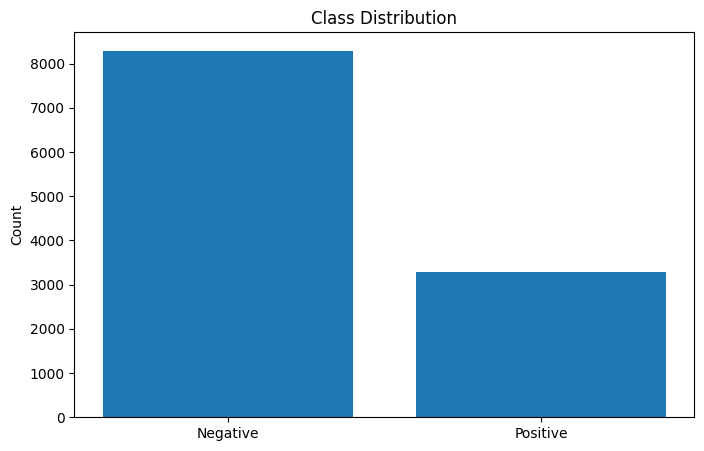

In [15]:
train_rle['has_pneumothorax'] = (train_rle[' EncodedPixels'] != ' -1')

positive = train_rle['has_pneumothorax'].sum()
negative = len(train_rle) - positive

print(f"Pneumothorax 있음: {positive} ({positive/len(train_rle)*100:.2f}%)")
print(f"Pneumothorax 없음: {negative} ({negative/len(train_rle)*100:.2f}%)")

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(['Negative', 'Positive'], [negative, positive])
plt.title('Class Distribution')
plt.ylabel('Count')
plt.show()

### DICOM 이미지 샘플

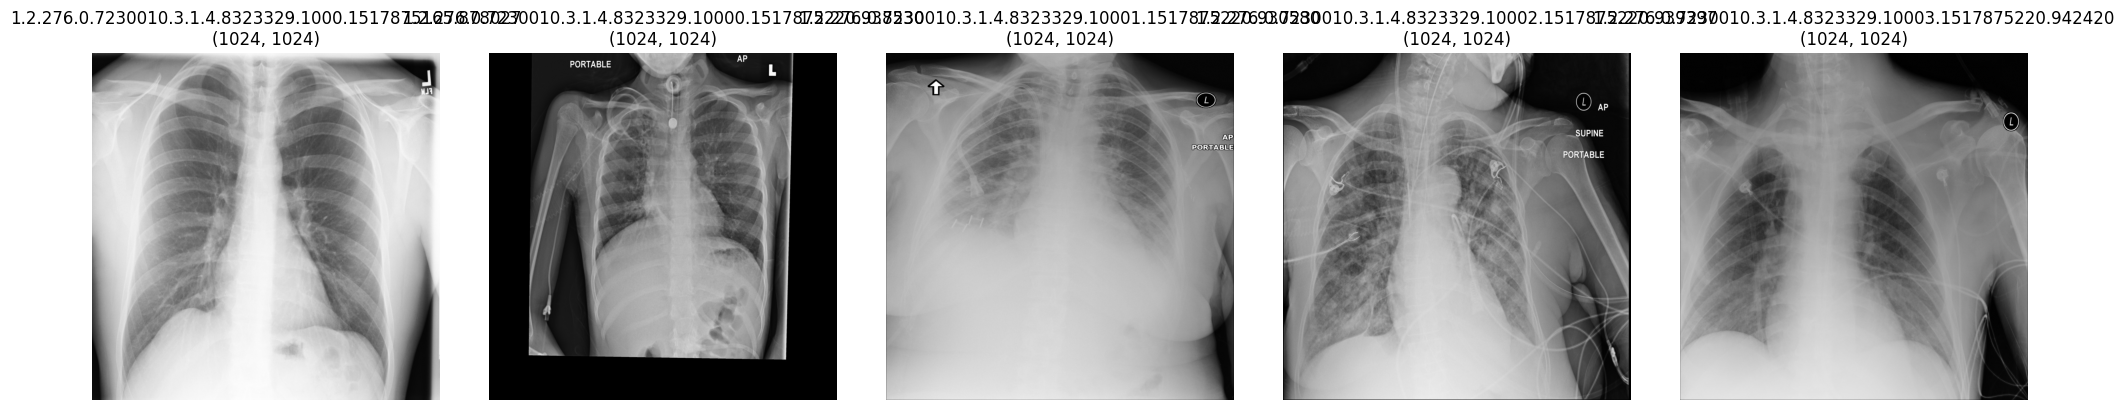

In [ ]:
sample_files = list(train_dicom_path.rglob('*.dcm'))[:5]

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, file_path in enumerate(sample_files):
    dcm = pydicom.dcmread(file_path)
    img = dcm.pixel_array
    
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f"{file_path.stem}\n{img.shape}")
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

### 이미지 크기
- (1024, 1024)로 크기 통일됨

In [ ]:
image_shapes = []
for file_path in list(train_dicom_path.rglob('*.dcm')):
    dcm = pydicom.dcmread(file_path)
    image_shapes.append(dcm.pixel_array.shape)

unique_shapes = pd.Series(image_shapes).value_counts()
print(unique_shapes)

Image shapes distribution (first 100 samples):
(1024, 1024)    10712
Name: count, dtype: int64


### RLE 인코딩 확인

In [ ]:
positive_samples = train_rle[train_rle['has_pneumothorax']].head(3)

for idx, row in positive_samples.iterrows():
    print(f"\nImageId: {row['ImageId']}")
    print(f"RLE (first 100 chars): {str(row[' EncodedPixels'])[:100]}...")


ImageId: 1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709
RLE (first 100 chars):  175349 7 1013 12 1009 17 1005 19 1003 20 1002 22 1001 22 1000 23 1000 23 1000 23 999 24 999 23 1000...

ImageId: 1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312
RLE (first 100 chars):  407576 2 1021 7 1015 10 1013 12 1011 14 1008 17 1006 19 1005 20 1003 21 1003 22 1001 23 1001 24 999...

ImageId: 1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312
RLE (first 100 chars):  252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1015 8 1014 9 1014 9 1013 10 1013 10 1012 11 1011 12 10...


175349 7 1013 12 1009 17 1005 19 ..
- 17539부터 7칸, 1013칸 이동 후에 12칸 .... <- masking 영역

### RLE decoding으로 마스크 시각화

In [ ]:
def rle_decode(rle, width, height):
    if pd.isna(rle) or str(rle).strip() == '-1':
        return np.zeros((height, width), dtype=np.uint8)
    
    array = np.asarray([int(x) for x in str(rle).strip().split()]) #RLE 문자열 -> int 리스트
    starts = array[0::2] #짝수 인덱스값 : mask 픽셀 사이 간격
    lengths = array[1::2] #홀수 인덱스 : mask 길이
    
    current_position = 0
    mask = np.zeros(width * height, dtype=np.uint8)
    
    for start, length in zip(starts, lengths):
        current_position += start
        mask[current_position:current_position+length] = 1
        current_position += length
    
    return mask.reshape(width, height).T

In [49]:
mask_sizes = []
for idx, row in train_rle[train_rle['has_pneumothorax']].iterrows():
    rle = row[' EncodedPixels']
    s = rle.split()
    lengths = np.asarray(s[1::2], dtype=int)
    total_size = lengths.sum()
    mask_sizes.append({'ImageId': row['ImageId'], 'mask_size': total_size})

mask_df = pd.DataFrame(mask_sizes).sort_values('mask_size', ascending=False)
print("Top 10 largest masks:")
print(mask_df.head(10))

Top 10 largest masks:
                                                ImageId  mask_size
2728  1.2.276.0.7230010.3.1.4.8323329.5498.151787518...     161421
648   1.2.276.0.7230010.3.1.4.8323329.5085.151787518...     145885
2799  1.2.276.0.7230010.3.1.4.8323329.1959.151787517...     134354
1713  1.2.276.0.7230010.3.1.4.8323329.12773.15178752...     126868
2106  1.2.276.0.7230010.3.1.4.8323329.574.1517875163...     117180
2723  1.2.276.0.7230010.3.1.4.8323329.5526.151787518...     107687
3019  1.2.276.0.7230010.3.1.4.8323329.5405.151787518...     104516
2845  1.2.276.0.7230010.3.1.4.8323329.11689.15178752...     102743
128   1.2.276.0.7230010.3.1.4.8323329.11858.15178752...      99119
2406  1.2.276.0.7230010.3.1.4.8323329.2915.151787517...      98093


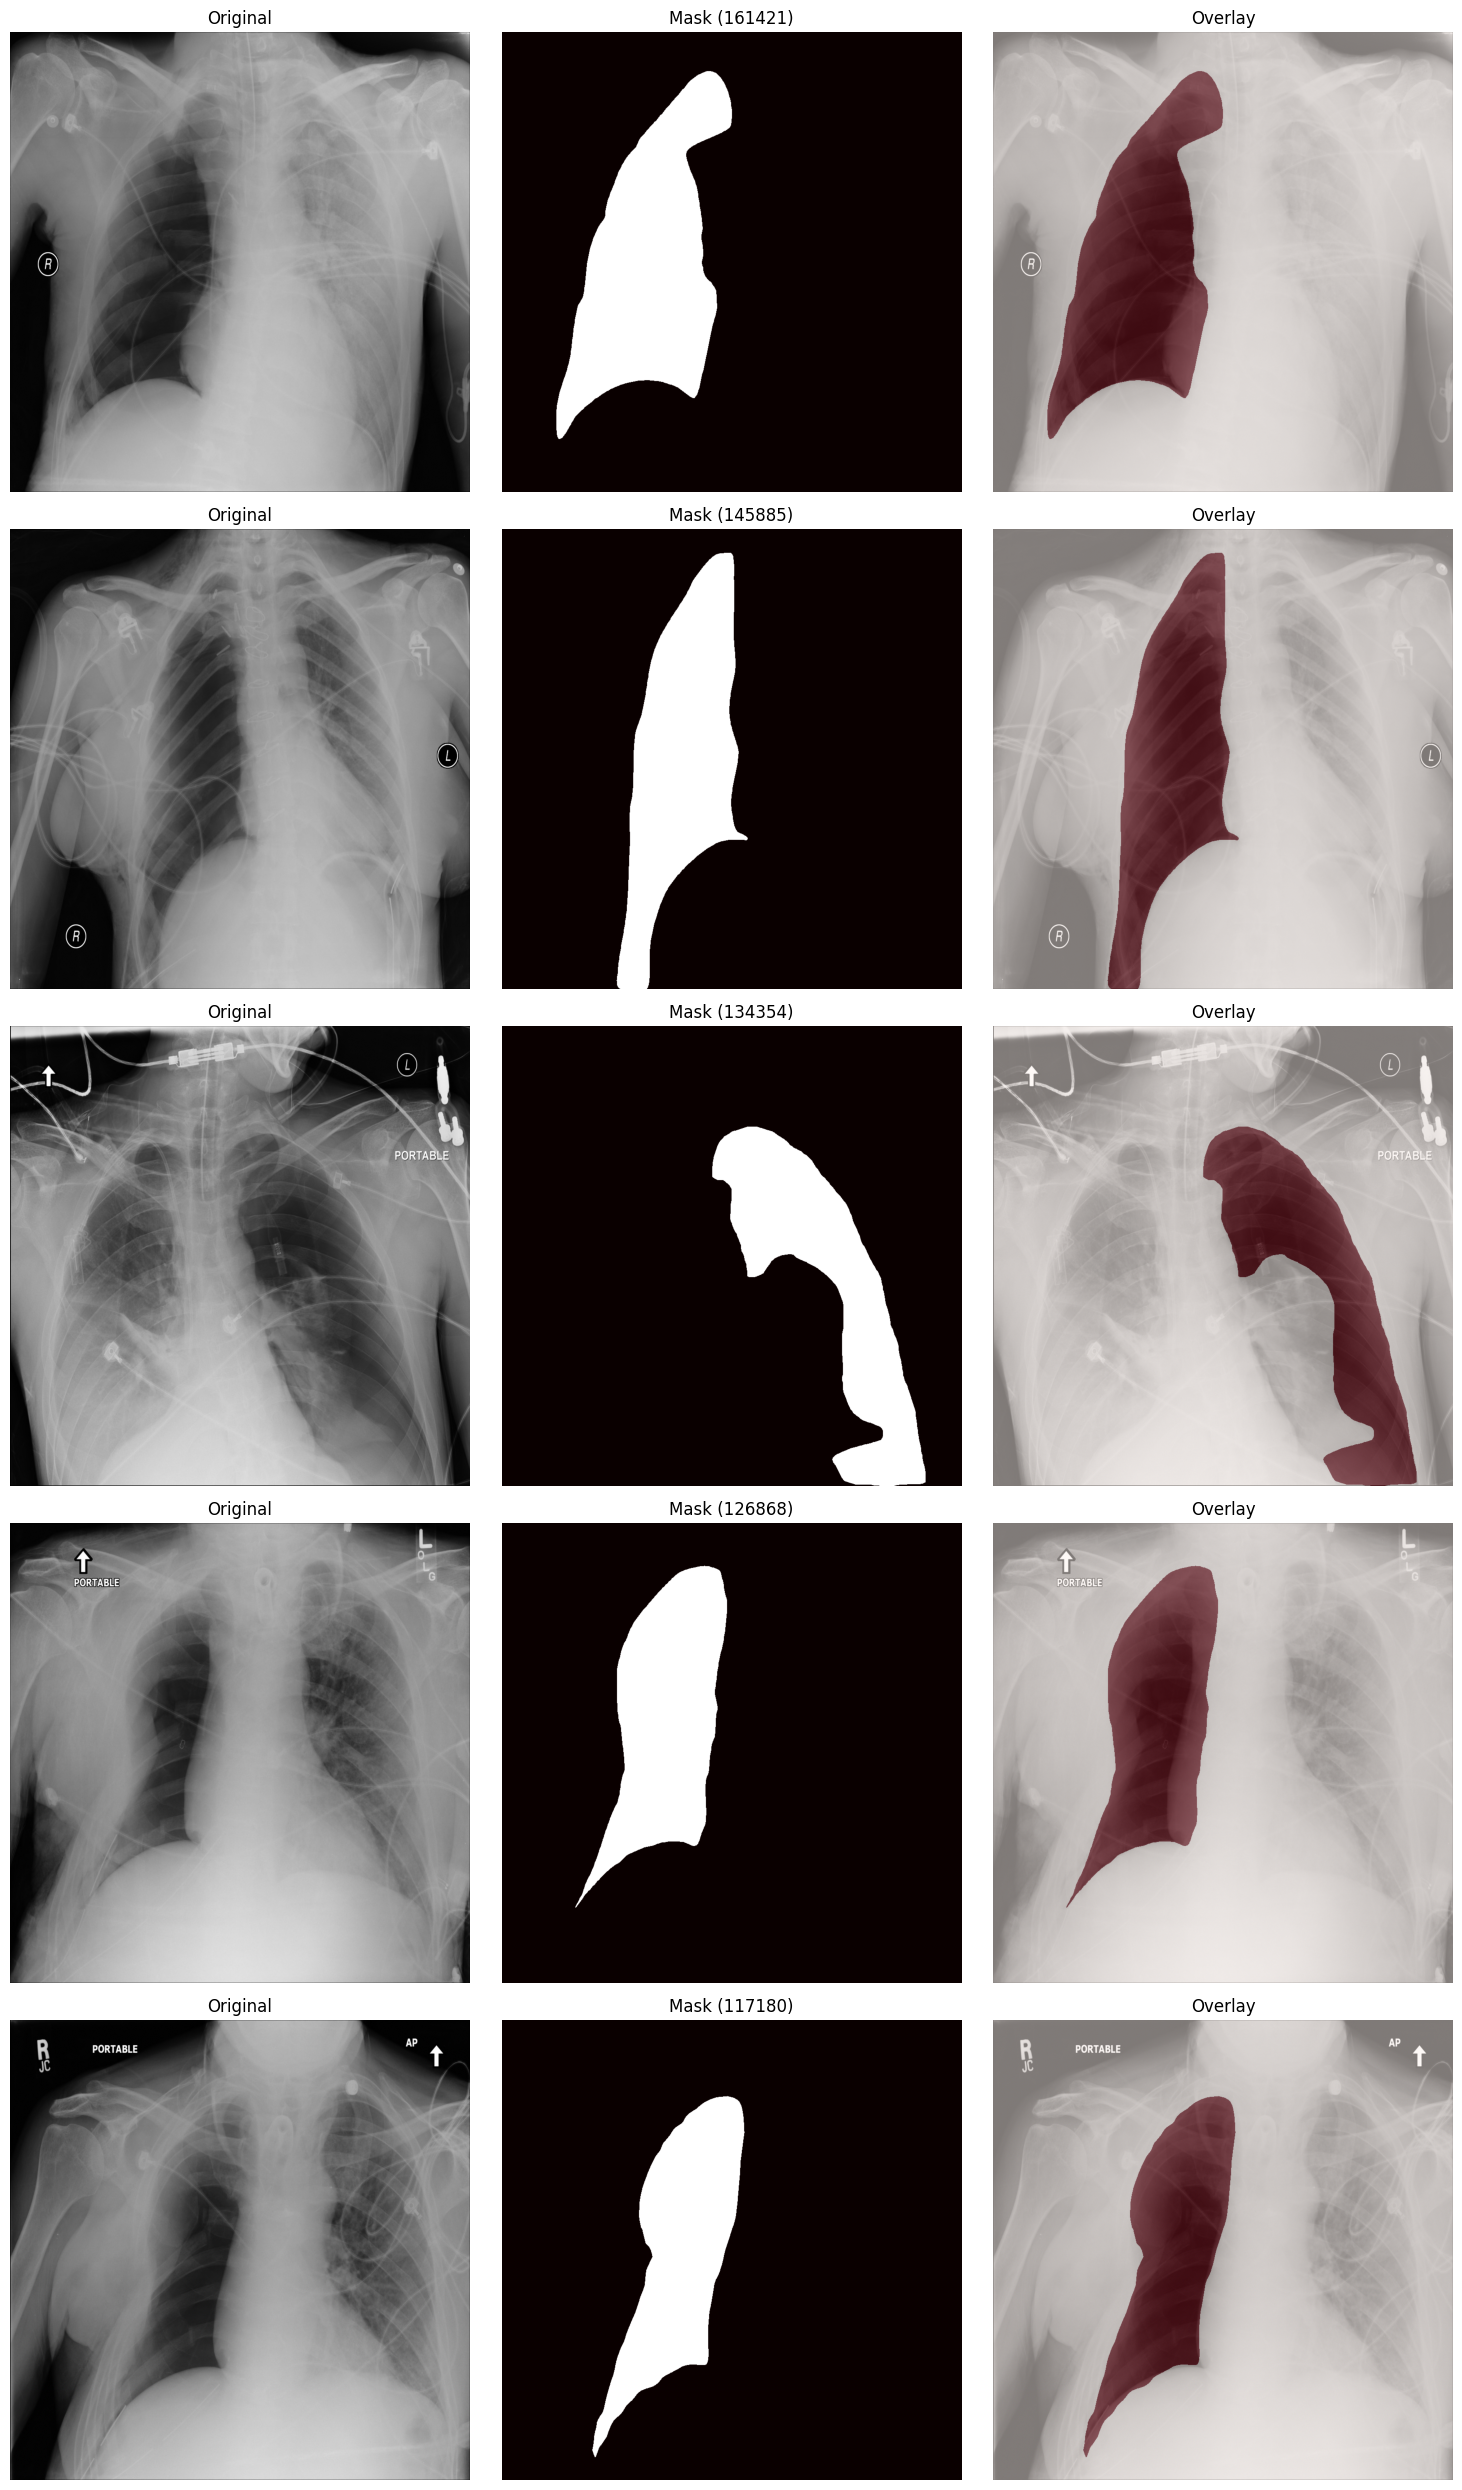

In [50]:
large_ids = mask_df.head(5)['ImageId'].values

fig, axes = plt.subplots(5, 3, figsize=(15, 25))
for idx, img_id in enumerate(large_ids):
    file_path = list(train_dicom_path.rglob(f'{img_id}.dcm'))[0]
    dcm = pydicom.dcmread(file_path)
    img = dcm.pixel_array
    
    rle = train_rle[train_rle['ImageId'] == img_id][' EncodedPixels'].values[0]
    mask = rle_decode(rle, 1024, 1024)
    
    axes[idx, 0].imshow(img, cmap='gray')
    axes[idx, 0].set_title('Original')
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(mask, cmap='hot')
    axes[idx, 1].set_title(f'Mask ({mask.sum()})')
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(img, cmap='gray')
    axes[idx, 2].imshow(mask, cmap='Reds', alpha=0.5)
    axes[idx, 2].set_title('Overlay')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

Top 10 small masks:
                                                ImageId  mask_size
2810  1.2.276.0.7230010.3.1.4.8323329.338.1517875162...         55
879   1.2.276.0.7230010.3.1.4.8323329.32421.15178751...         80
902   1.2.276.0.7230010.3.1.4.8323329.32462.15178751...        123
380   1.2.276.0.7230010.3.1.4.8323329.12376.15178752...        201
1565  1.2.276.0.7230010.3.1.4.8323329.31716.15178751...        210
329   1.2.276.0.7230010.3.1.4.8323329.12786.15178752...        212
1527  1.2.276.0.7230010.3.1.4.8323329.31952.15178751...        219
1172  1.2.276.0.7230010.3.1.4.8323329.31964.15178751...        220
1043  1.2.276.0.7230010.3.1.4.8323329.4343.151787518...        222
338   1.2.276.0.7230010.3.1.4.8323329.5396.151787518...        252


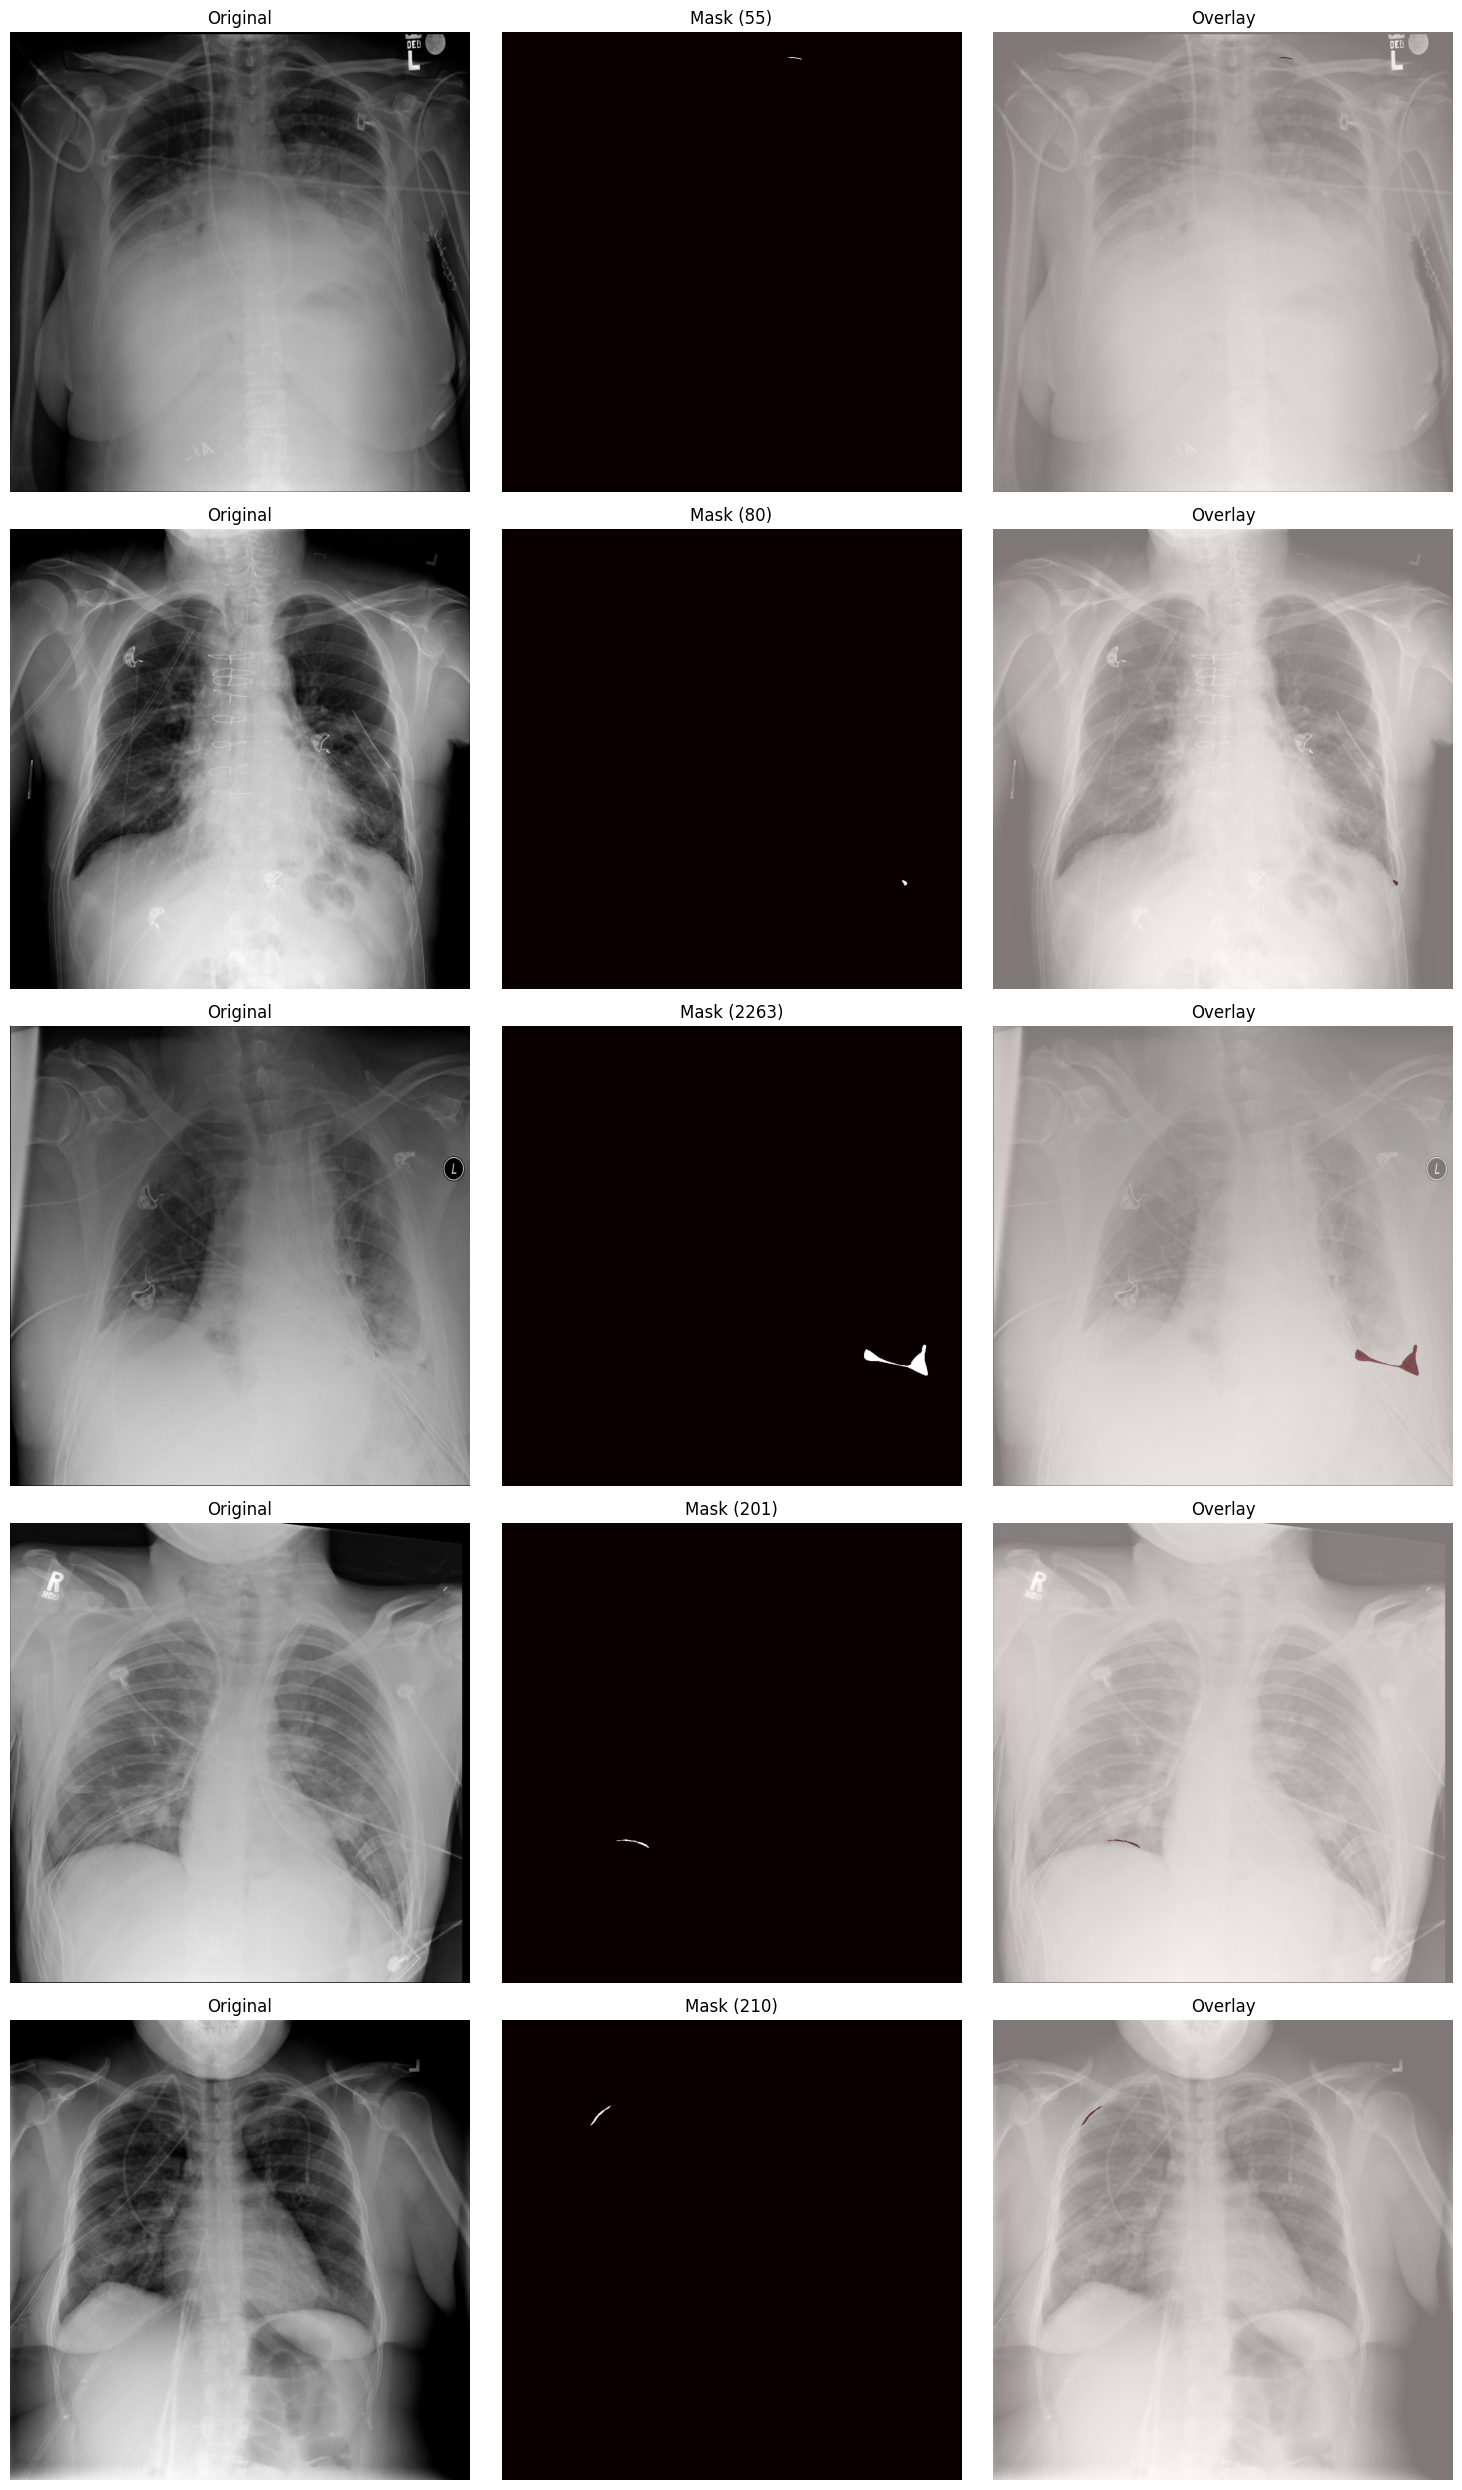

In [54]:
mask_sizes = []
for idx, row in train_rle[train_rle['has_pneumothorax']].iterrows():
    rle = row[' EncodedPixels']
    s = rle.split()
    lengths = np.asarray(s[1::2], dtype=int)
    total_size = lengths.sum()
    mask_sizes.append({'ImageId': row['ImageId'], 'mask_size': total_size})

mask_df_min = pd.DataFrame(mask_sizes).sort_values('mask_size', ascending=True)
print("Top 10 small masks:")
print(mask_df_min.head(10))

small_ids = mask_df_min.head(5)['ImageId'].values

fig, axes = plt.subplots(5, 3, figsize=(15, 25))
for idx, img_id in enumerate(small_ids):
    file_path = list(train_dicom_path.rglob(f'{img_id}.dcm'))[0]
    dcm = pydicom.dcmread(file_path)
    img = dcm.pixel_array
    
    rle = train_rle[train_rle['ImageId'] == img_id][' EncodedPixels'].values[0]
    mask = rle_decode(rle, 1024, 1024)
    
    axes[idx, 0].imshow(img, cmap='gray')
    axes[idx, 0].set_title('Original')
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(mask, cmap='hot')
    axes[idx, 1].set_title(f'Mask ({mask.sum()})')
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(img, cmap='gray')
    axes[idx, 2].imshow(mask, cmap='Reds', alpha=0.5)
    axes[idx, 2].set_title('Overlay')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

### mask 크기 분포


Mask area statistics:
Mean: 10836 pixels (1.03%)
Median: 6250 pixels
Min: 55 pixels
Max: 161421 pixels


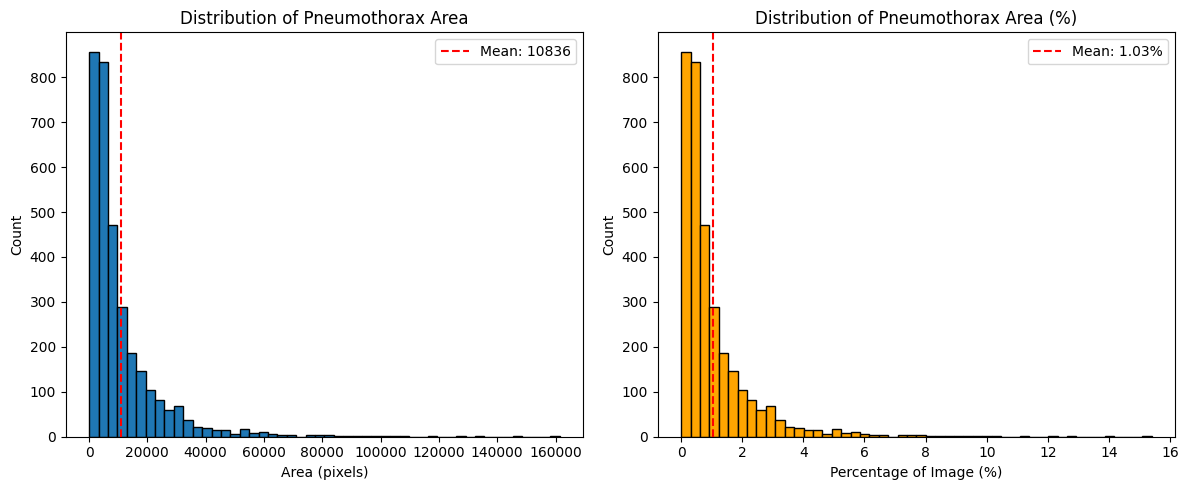

In [52]:
mask_areas = []
for _, row in train_rle[train_rle['has_pneumothorax']].iterrows():
    mask = rle_decode(row[' EncodedPixels'], 1024, 1024)
    mask_areas.append(mask.sum())

mask_areas = np.array(mask_areas)

print(f"\nMask area statistics:")
print(f"Mean: {mask_areas.mean():.0f} pixels ({mask_areas.mean()/(1024*1024)*100:.2f}%)")
print(f"Median: {np.median(mask_areas):.0f} pixels")
print(f"Min: {mask_areas.min():.0f} pixels")
print(f"Max: {mask_areas.max():.0f} pixels")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(mask_areas, bins=50, edgecolor='black')
plt.title('Distribution of Pneumothorax Area')
plt.xlabel('Area (pixels)')
plt.ylabel('Count')
plt.axvline(mask_areas.mean(), color='red', linestyle='--', label=f'Mean: {mask_areas.mean():.0f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(mask_areas/(1024*1024)*100, bins=50, edgecolor='black', color='orange')
plt.title('Distribution of Pneumothorax Area (%)')
plt.xlabel('Percentage of Image (%)')
plt.ylabel('Count')
plt.axvline(mask_areas.mean()/(1024*1024)*100, color='red', linestyle='--', 
            label=f'Mean: {mask_areas.mean()/(1024*1024)*100:.2f}%')
plt.legend()

plt.tight_layout()
plt.show()

- 대부분 pneumothorax영역이 작다. 평균 : 10836 픽셀
- 클래스 불균형 : 양성 샘플 자체가 매우 적음(22%), 양성 샘플도 영역이 작은게 대부분
- False Negative가 높을 것으로 예상됨

### 픽셀 강도 분포
- 이미지 간 밝기 편차가 꽤 큼 (오른쪽 Boxplot)
- 매우 어두운 픽셀(배경) 비율이 높은 편

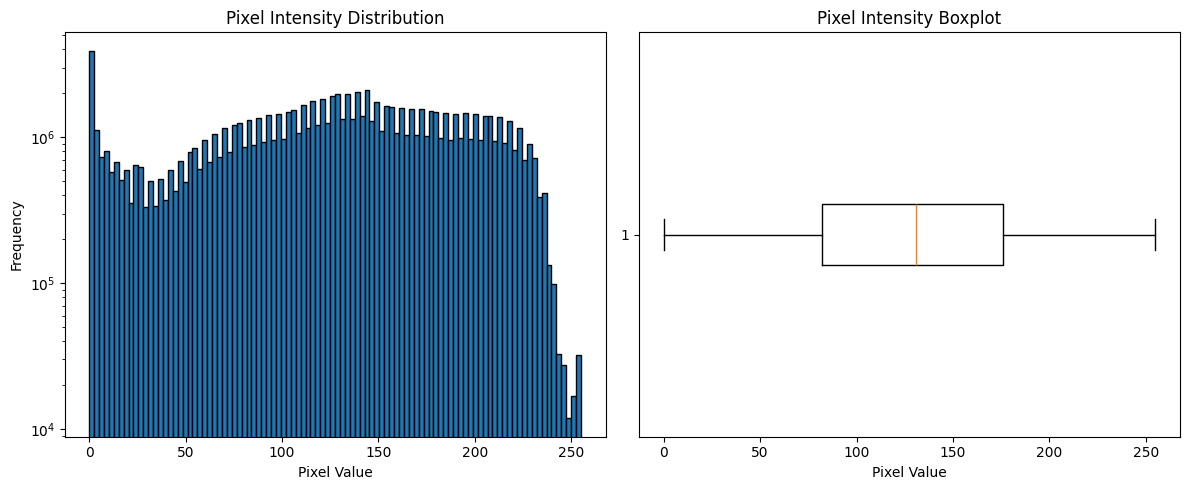

In [58]:
# 7. 이미지 픽셀 값 분포
sample_images = []
for file_path in list(train_dicom_path.rglob('*.dcm'))[:100]:
    dcm = pydicom.dcmread(file_path)
    sample_images.append(dcm.pixel_array.flatten())

all_pixels = np.concatenate(sample_images)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(all_pixels, bins=100, edgecolor='black')
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.boxplot(all_pixels, vert=False)
plt.title('Pixel Intensity Boxplot')
plt.xlabel('Pixel Value')

plt.tight_layout()
plt.show()